In [53]:
# Import basic packages 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Predictive Model packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression 

#### A user table ("takehome_users") with data on 12,000 users who signed up for the product in the last two years. This table includes:
    ● name: the user's name
    ● object_id: the user's id
    ● email: email address
    ● creation_source: how their account was created. This takes on one of 5 values:
    ○ PERSONAL_PROJECTS: invited to join another user's personal workspace
    ○ GUEST_INVITE: invited to an organization as a guest (limited permissions)
    ○ ORG_INVITE: invited to an organization (as a full member)
    ○ SIGNUP: signed up via the website
    ○ SIGNUP_GOOGLE_AUTH: signed up using Google Authentication (using a Google email account for their login id)
    ● creation_time: when they created their account
    ● last_session_creation_time: unix timestamp of last login
    ● opted_in_to_mailing_list: whether they have opted into receiving marketing emails
    ● enabled_for_marketing_drip: whether they are on the regular marketing email drip
    ● org_id: the organization (group of users) they belong to
    ● invited_by_user_id: which user invited them to join (if applicable).

#### A usage summary table ("takehome_user_engagement") that has a row for each day that a user logged into the product.
    Defining an "adopted user" as a user who has logged into the product on three separate days in at least
    one seven day period, identify which factors predict future user adoption.



In [2]:
# import the two dara sets as DataFrames
user_engage = pd.read_csv('takehome_user_engagement.csv')

In [3]:
users = pd.read_csv('takehome_users.csv',encoding='ISO-8859-1')

In [4]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [6]:
# Convert datetime columns 
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'])

In [7]:
# Check for nan
users.isna().sum()

object_id                        0
creation_time                    0
name                             0
email                            0
creation_source                  0
last_session_creation_time    3177
opted_in_to_mailing_list         0
enabled_for_marketing_drip       0
org_id                           0
invited_by_user_id            5583
dtype: int64

In [8]:
users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0


Basic cleaning for users df is near complete, last_session_creation_time & invited_by_user_id are floats due to missing values. last_session_creation_time appears to be recorded improperly and will be dropped as it is not usefull to answer the main question. invited_by_user_id will have nan values filled with 0 to indicate they joined without being invited. Afterwards data processing will be conducted on user_engage df to define a returned user and joined on object_id and user_id. 

In [9]:
users.drop(columns='last_session_creation_time', inplace=True)

In [10]:
users.fillna(value=0, inplace=True)

In [11]:
users['invited_by_user_id']=users['invited_by_user_id'].astype(np.int64)

In [12]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   opted_in_to_mailing_list    12000 non-null  int64         
 6   enabled_for_marketing_drip  12000 non-null  int64         
 7   org_id                      12000 non-null  int64         
 8   invited_by_user_id          12000 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(3)
memory usage: 843.9+ KB


In [13]:
# Being processing for user_engage df
user_engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [14]:
user_engage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


### Data Wrangling: Processing 'user_engage'  dataframe 

In [15]:
# Convert 'time_stamp' to date-time
user_engage['time_stamp'] = pd.to_datetime(user_engage['time_stamp'])

In [16]:
# Sort valeus by time_stamp to be in chronological order
user_engage.sort_values(by='time_stamp', inplace=True)
user_engage.reset_index(inplace=True, drop=True)


In [17]:
user_engage.head(5)

,time_stamp,user_id,visited
0,2012-05-31 08:20:06,10012,1
1,2012-05-31 15:47:36,3428,1
2,2012-05-31 17:19:37,9899,1
3,2012-05-31 21:58:33,1693,1
4,2012-06-01 00:17:30,6102,1


In [18]:
# Investigate the visited column, I suspect that the entire column is just 1 
user_engage['visited'].describe()

count    207917.0
mean          1.0
std           0.0
min           1.0
25%           1.0
50%           1.0
75%           1.0
max           1.0
Name: visited, dtype: float64

Given the info from the given pdf that user_engagement has a row for each day a user logged into the product and visted is 1, I will assume that a user does not log in multiple times in a day and create weekly time segements

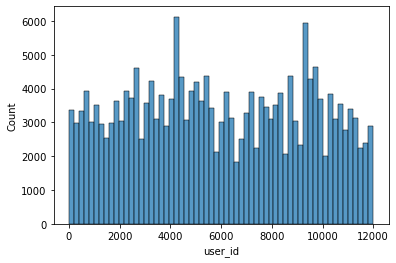

In [19]:
# Investigate user_id using a histogram to see the distrobution of repeated logins 
_ = sns.histplot(data=user_engage, x='user_id')

In [20]:
# Investigate the first and last login date 
print('First user engagement login:', min(user_engage['time_stamp']))
print('Last user engagement login:', max(user_engage['time_stamp']))

First user engagement login: 2012-05-31 08:20:06
Last user engagement login: 2014-06-06 14:58:50


In [21]:
# Create a date column with year-month-day
user_engage['date'] = pd.to_datetime(user_engage['time_stamp']).dt.date

In [22]:
user_engage.head(5)

,time_stamp,user_id,visited,date
0,2012-05-31 08:20:06,10012,1,2012-05-31
1,2012-05-31 15:47:36,3428,1,2012-05-31
2,2012-05-31 17:19:37,9899,1,2012-05-31
3,2012-05-31 21:58:33,1693,1,2012-05-31
4,2012-06-01 00:17:30,6102,1,2012-06-01


In [23]:
user_engage.index=user_engage.time_stamp

In [24]:
user_engage.head(2)

,time_stamp,user_id,visited,date
time_stamp,,,,
2012-05-31 08:20:06,2012-05-31 08:20:06,10012,1,2012-05-31
2012-05-31 15:47:36,2012-05-31 15:47:36,3428,1,2012-05-31


In [25]:
user_engage.drop(labels='time_stamp',axis=1,inplace=True)
user_engage.head(2)

,user_id,visited,date
time_stamp,,,
2012-05-31 08:20:06,10012,1,2012-05-31
2012-05-31 15:47:36,3428,1,2012-05-31


In [26]:
# Group by user_id and resample to 1 week period, sum over period
df_agg = user_engage.groupby([pd.Grouper(freq='W'),'user_id']).sum()

In [27]:
df_agg.head(40)

visited
time_stamp user_id         
2012-06-03 563            1
           1693           1
           1995           1
           2120           1
           2136           1
           2494           1
           2568           1
           3428           1
           3514           1
           3721           1
           3861           1
           4584           1
           5694           1
           6047           1
           6102           1
           7170           1
           7286           1
           7991           1
           8068           1
           8991           1
           9394           1
           9899           1
           9964           1
           10012          1
           10163          1
           10628          1
           10922          1
           11297          1
           11430          1
           11999          1
2012-06-10 47             1
           50             1
           178            1
           510            1
           822            2
           1400           1
           1525           1
           1551           1
           1619           1
           1693           3

In [28]:
# Find all user id's with a sum of 3 or more, indicating an adopted user
df_adopt = df_agg[df_agg.visited >= 3].unstack(level = 1).melt()

In [29]:
df_adopt.head(2)

,None,user_id,value
0,visited,1693,3.0
1,visited,1693,NaN


In [30]:
# Create df with just the adopted user's id
adopted_users = pd.DataFrame(df_adopt.user_id.unique(),index = range(df_adopt.user_id.unique().shape[0]),columns = ['user_id'])

In [31]:
adopted_users.head(5)

,user_id
0,1693
1,728
2,11764
3,5297
4,6171


In [32]:
adopted_users['adopted'] = 1

In [33]:
adopted_users.head(5)

,user_id,adopted
0,1693,1
1,728,1
2,11764,1
3,5297,1
4,6171,1


In [34]:
# Verfication that user_id 1694 is in the adopted_user dataframe 
adopted_users.loc[adopted_users['user_id'] == 1694]

,user_id,adopted
408,1694,1


In [35]:
df_join = users.merge(adopted_users, how='left', left_on='object_id', right_on='user_id')
df_join.head(10)

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,NaN,NaN
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,2.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,NaN,NaN
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,NaN,NaN
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,NaN,NaN
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,0,0,197,11241,NaN,NaN
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,0,1,37,0,NaN,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,1,1,74,0,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,0,0,302,0,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1,1,318,4143,10.0,1.0


In [36]:
# Set non-adopted = 0 & adopted = 1
df_join['adopted'].fillna(value=0,inplace=True)

In [37]:
df_join['adopted'].describe()

count    12000.000000
mean         0.120417
std          0.325462
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: adopted, dtype: float64

12% of the data set is comprised of adopted users, thus, we have a 90/10 split of non-adopted to adopted users

In [38]:
df_join.head(5)

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1,0,11,10803,NaN,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,0,0,1,316,2.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,0,0,94,1525,NaN,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,0,0,1,5151,NaN,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,0,0,193,5240,NaN,0.0


In [39]:
df_join.iloc[1692:1696]

,object_id,creation_time,name,email,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,user_id,adopted
1692,1693,2012-05-31 21:58:33,Faulkner Hayden,HaydenFaulkner@gmail.com,SIGNUP_GOOGLE_AUTH,0,1,50,0,1693.0,1.0
1693,1694,2013-02-07 17:53:20,Barros Aline,AlineCardosoBarros@hotmail.com,PERSONAL_PROJECTS,1,1,66,0,1694.0,1.0
1694,1695,2013-09-29 07:38:15,Patrick Lincoln,paimltlx@hsskw.com,SIGNUP,0,0,18,0,NaN,0.0
1695,1696,2014-05-05 18:00:46,Rocha Tiago,TiagoFernandesRocha@cuvox.de,PERSONAL_PROJECTS,0,0,89,0,NaN,0.0


In [40]:
df_join['adopted'].value_counts()

0.0    10555
1.0     1445
Name: adopted, dtype: int64

In [41]:
# drop unecessary columns
drop_cols = list(df_join.columns[0:4])
drop_cols.append('user_id')
df_join = df_join.drop(drop_cols,axis=1)

In [42]:
df_join.head(5)

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,GUEST_INVITE,1,0,11,10803,0.0
1,ORG_INVITE,0,0,1,316,1.0
2,ORG_INVITE,0,0,94,1525,0.0
3,GUEST_INVITE,0,0,1,5151,0.0
4,GUEST_INVITE,0,0,193,5240,0.0


In [43]:
# Identify the unique values in creation_source
df_join.creation_source.value_counts(normalize=True)*100

ORG_INVITE            35.450000
GUEST_INVITE          18.025000
PERSONAL_PROJECTS     17.591667
SIGNUP                17.391667
SIGNUP_GOOGLE_AUTH    11.541667
Name: creation_source, dtype: float64

<AxesSubplot:xlabel='creation_source', ylabel='Count'>

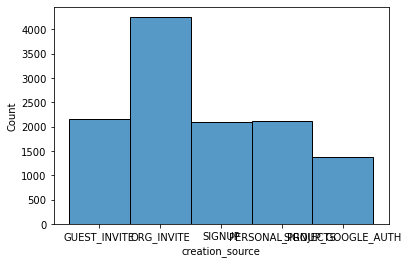

In [44]:
sns.histplot(data=df_join, x='creation_source', legend=True)

We can see that organization invite is the greatest source of account creation. Since there is only 5 variables in 'creation_source' I will one-hot encode for a random forest model.

In [45]:
# One hot enocode 'creation_source'
df_join = pd.get_dummies(df_join, columns=['creation_source'])

In [46]:
df_join.head(5)

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,0.0,1,0,0,0,0
1,0,0,1,316,1.0,0,1,0,0,0
2,0,0,94,1525,0.0,0,1,0,0,0
3,0,0,1,5151,0.0,1,0,0,0,0
4,0,0,193,5240,0.0,1,0,0,0,0


In [47]:
# Generate y (target/independent feature) = adopted values
y = df_join['adopted'].values

In [48]:
# Drop target feature (adopted) in df_base 
df_base = df_join.drop('adopted', axis=1)

In [50]:
# Generate X (dependent features) = df_base values
X = df_base.values

In [51]:
# Verify first row of X
X[0]

array([    1,     0,    11, 10803,     1,     0,     0,     0,     0])

In [55]:
# Split the data set: 80% Train, 20% Test, stratify based on y to preserve the 90/10 split in test & train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

In [56]:
# Scale the data
scaler = StandardScaler() 
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
# Check X_train
X_train[0] 

array([-0.57494463, -0.41888211, -0.9845525 ,  1.83222647, -0.46504578,
        1.33393636, -0.45690648, -0.45640674, -0.36452302])

In [58]:
# Build Random Forest 
rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [59]:
rf.score(X_test, y_test)

0.8425

In [60]:
print(cross_val_score(rf,X_test,np.ravel(y_test),cv=5))
print('Mean Cross Validated Score:',np.mean(cross_val_score(rf,X_test,np.ravel(y_test),cv=5)))

[0.8375     0.825      0.82083333 0.84583333 0.825     ]
Mean Cross Validated Score: 0.82875


In [62]:
df_importance = pd.DataFrame(zip(list(df_base.columns),rf.feature_importances_),
                             index=range(df_base.columns.shape[0]),columns=['feature','importance'])
df_importance.sort_values(by='importance',ascending=False)

,feature,importance
2,org_id,0.616042
3,invited_by_user_id,0.342824
0,opted_in_to_mailing_list,0.013016
1,enabled_for_marketing_drip,0.011165
6,creation_source_PERSONAL_PROJECTS,0.005223
4,creation_source_GUEST_INVITE,0.003776
5,creation_source_ORG_INVITE,0.003072
8,creation_source_SIGNUP_GOOGLE_AUTH,0.002689
7,creation_source_SIGNUP,0.002194


The top three most important features are organization id, invited by user, and opted to mailing list.

These features account for most of the variation when determing an adopted user, meaning these features are highly predictive for a future adopted user. 

In [76]:
#Logistic model to give value to the feature importance found in the random forest model, a logestic regression 
# is used as most of the features are categorical. 

# Intialize logistic model 
logit = LogisticRegression(solver = 'lbfgs')

#set parameter grid, no one knows what is a good range, if the accuracy is not good then you increase the range.
param_grid = {'C':np.arange(.1,1,.5)}

#instantiate and fit grid search object
grid = GridSearchCV(logit,param_grid,cv=5)
grid.fit(X_train,np.ravel(y_train))

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([0.1, 0.6])})

In [77]:
grid.best_estimator_.C

0.1

In [78]:
#find coefficients from Logistic Regression
logit_coef = LogisticRegression(C=grid.best_estimator_.C)
logit_coef.fit(X_train,y_train)
df_coef = pd.DataFrame(zip(list(df_base.columns),logit_coef.coef_[0]),index=range
                       (df_base.columns.shape[0]),columns=['feature','coefficient'])
df_coef.sort_values(by='coefficient',ascending=False)

,feature,coefficient
2,org_id,0.191915
4,creation_source_GUEST_INVITE,0.120772
8,creation_source_SIGNUP_GOOGLE_AUTH,0.089309
0,opted_in_to_mailing_list,0.044598
7,creation_source_SIGNUP,0.034376
1,enabled_for_marketing_drip,0.014187
3,invited_by_user_id,-0.007307
5,creation_source_ORG_INVITE,-0.013707
6,creation_source_PERSONAL_PROJECTS,-0.215137


In [79]:
print(np.mean(cross_val_score(grid, X_test, np.ravel(y_test), cv=5)))

0.8795833333333333


According to the top features from the random forest model, organization id, invited by user, and opted to mailing list, the corresponding coefficients from the logistic regression are:

org_id = 0.191915
invited_by_user_id = -0.007307
opted_in_to_mailing_list = 0.044598

Accordingly, organization id is responsible for the largest predictor of generating an adopted user at 19%, thus, the reccommendation will be to increase use of the product within an organization. Next, invited by a user had a negative relationship to predicted an adopted user, but by a marginal amout of -.7%, thus, this prediction could be taken lightly. Lastly, opting into the mailing list predicted an adopted user at 4%, thus, it can be reccommened to keep efforts to increase mail list subscription. 

An issue with my findings if given more time is to increase hyperparamter testing and using other models in order to increase the accuracy of 88% to over 90%. Becuase the data had a 90/10 split in non-adopted to adopted users the goal accuracy is over 90%, for greater statistical significance. At 88% accuracy there is reason for further testing.  